## Initial Customer data

- Due to regulatory and privacy concerns, and also the need for data with comprehensive demographic features, spanning a broader timeframe,  we shall simulate raw lending data since none of such nature could be found.

- We shall however ensure the data reflects real-world relationships and scenarios as much as possible.


In [ ]:
# Simulate LendingClub-like loan data with demographic and regional variables
# Run in Colab. Outputs ~120k rows by default.
import numpy as np
import pandas as pd
from itertools import product

np.random.seed(42)

# Parameters
years = np.arange(2015, 2026)   # 2015..2025
months = np.arange(1, 13)       # monthly granularity
rows_per_month = 100          # controls dataset size: ~120k rows total

# Region-level macro variables (simulate unemployment and shock sensitivity)
regions = ['NE', 'MW', 'S', 'W']  # northeast, midwest, south, west
region_base_unemp = {'NE': 0.05, 'MW': 0.045, 'S': 0.055, 'W': 0.048}

records = []

for year in years:
    for month in months:
        n = rows_per_month
        # base economic cycle: higher baseline default in 2020-2021
        base_default_shift = 0.0
        if year in (2020, 2021):
            base_default_shift = 0.05
        elif year >= 2023:
            base_default_shift = -0.02

        # For each row sample demographic and region
        region = np.random.choice(regions, size=n, p=[0.25, 0.25, 0.30, 0.20])
        # region unemployment: base + year trend + random noise
        region_unemp = np.array([region_base_unemp[r] for r in region]) \
                      + 0.002 * (year - 2015) \
                    + np.random.normal(0, 0.005, n)

        # Demographics: gender, race, age_group, education, employment_status
        gender = np.random.choice(['male', 'female'], size=n, p=[0.48, 0.52])
        race = np.random.choice(['white', 'black', 'asian', 'hispanic', 'other'],
                                size=n, p=[0.60, 0.12, 0.10, 0.12, 0.06])
        # age groups with modest drift toward older applicants over time
        age_group = np.random.choice(['18-29','30-44','45-59','60+'],
                                    size=n, p=[0.25, 0.40, 0.25, 0.10])
        # education proxies
        education = np.random.choice(['highschool','bachelor','master','phd','other'],
                                    size=n, p=[0.35, 0.35, 0.18, 0.03, 0.09])

        # Employment status: simple model with a dip during pandemic years
        employment_statuses = ['employed', 'unemployed', 'self-employed']
        employment_probs = [0.85, 0.05, 0.10] # Base probabilities
        if year in (2020, 2021):
            employment_probs = [0.75, 0.15, 0.10] # Higher unemployment during pandemic
        elif year >= 2023:
            employment_probs = [0.88, 0.03, 0.09] # Lower unemployment post-pandemic

        employment_status = np.random.choice(employment_statuses, size=n, p=employment_probs)


        # Income correlated with education, region, race and employment status
        edu_income_map = {'highschool': 42000, 'bachelor': 65000, 'master': 85000, 'phd': 110000, 'other': 38000}
        race_income_factor = {'white': 1.0, 'black': 0.82, 'asian': 1.15, 'hispanic': 0.9, 'other': 0.95}
        region_income_factor = {'NE':1.05, 'MW':0.95, 'S':0.9, 'W':1.10}
        emp_income_factor = {'employed': 1.0, 'unemployed': 0.2, 'self-employed': 0.9} # Unemployed have much lower income

        base_income = np.array([edu_income_map[e] for e in education]) \
                      * np.array([race_income_factor[r] for r in race]) \
                      * np.array([region_income_factor[rgn] for rgn in region]) \
                      * np.array([emp_income_factor[emp] for emp in employment_status]) # Include employment factor

        # add year inflation growth and noise
        annual_income = base_income + (year - 2015) * 2000 + np.random.normal(0, 10000, n)
        annual_income = np.clip(annual_income, 8000, None)

        # credit_score correlated with income and education and with some racial disparity noise
        credit_score = 650 \
                       + (annual_income - 50000) / 2000 \
                       + np.array([10 if e in ('master','phd') else 0 for e in education]) \
                       + np.random.normal(0, 35, n)
        # small downward bias for some groups to model structural disadvantage
        credit_score -= np.array([5 if r in ('black','hispanic') else 0 for r in race])
        credit_score = np.clip(credit_score, 300, 850)

        # loan_amount correlated with income and year inflation
        loan_amount = np.random.normal(0.25 * annual_income, 4000, n) \
                      + (year - 2015) * 200
        loan_amount = np.clip(loan_amount, 1000, None)

        # debt-to-income: higher for some age groups and after shocks
        base_dti = 0.20 + (age_group == '18-29') * 0.05 + (age_group == '60+') * -0.01
        dti = np.clip(base_dti + np.random.normal(0, 0.07, n) + 0.01*(region_unemp-0.05), 0, 1)

        # interest rate depends on credit_score, loan_amount, and yearly market premium
        market_premium = 0.01 + 0.002 * (year - 2015)
        # 2022+ higher rates
        if year >= 2022:
            market_premium += 0.015
        interest_rate = 0.10 - 0.0006 * credit_score + 0.00001 * loan_amount + market_premium + np.random.normal(0, 0.01, n)
        interest_rate = np.clip(interest_rate, 0.01, 0.40)

        # Build default probability with multiple components:
        # baseline logit + credit_score effect + dti effect + unemployment effect + year shock + race-specific vulnerability + employment status effect
        logit = -3.8 \
                + 0.00008 * loan_amount \
                + 3.5 * dti \
                - 0.006 * (credit_score - 700) \
                + 5.0 * (region_unemp - 0.05) \
                + base_default_shift \
                + np.array([-0.2 if emp == 'employed' else (0.5 if emp == 'unemployed' else 0.1) for emp in employment_status]) # Add employment status effect

        # Introduce race-specific increased vulnerability in downturn years to simulate disparate impact
        race_vulnerability = {'white':0.0, 'black':0.15, 'asian':-0.05, 'hispanic':0.08, 'other':0.02}
        if year in (2020, 2021):  # pandemic period amplifies disparities
            logit += np.array([race_vulnerability[r] for r in race])

        p_default = 1 / (1 + np.exp(-logit))
        default = np.random.binomial(1, np.clip(p_default, 0, 1))

        issue_date = pd.to_datetime({
            'year': np.repeat(year, n),
            'month': np.repeat(month, n),
            'day': np.random.randint(1,28,size=n)
        })

        df_month = pd.DataFrame({
            'applicant_id': [f"{year}{month:02d}_{i}" for i in range(n)],
            'issue_date': issue_date,
            'year': year,
            'month': month,
            'region': region,
            'region_unemp': region_unemp,
            'gender': gender,
            'race': race,
            'age_group': age_group,
            'education': education,
            'employment_status': employment_status, # Added employment status
            'annual_income': annual_income,
            'credit_score': credit_score,
            'loan_amount': loan_amount,
            'debt_to_income': dti,
            'interest_rate': interest_rate,
            'default': default
        })
        records.append(df_month)

# Combine and tidy
df = pd.concat(records, ignore_index=True)
df['credit_score'] = df['credit_score'].round(0).astype(int)
df['interest_rate'] = df['interest_rate'].round(4)
df['debt_to_income'] = df['debt_to_income'].round(3)
df['loan_amount'] = df['loan_amount'].round(2)
df['annual_income'] = df['annual_income'].round(2)

print("Rows:", df.shape[0])
print("Years present:", df['year'].nunique(), sorted(df['year'].unique()))
print(df.head(6))

# Save simulated dataset to CSV for later use
df.to_csv("./data/raw/lending_data.csv", index=False)

Rows: 13200
Years present: 11 [2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]
  applicant_id issue_date  year  month region  region_unemp  gender   race  \
0     201501_0 2015-01-14  2015      1     MW      0.045435  female  white   
1     201501_1 2015-01-04  2015      1      W      0.046505  female  asian   
2     201501_2 2015-01-06  2015      1      S      0.055459  female  white   
3     201501_3 2015-01-19  2015      1      S      0.045062  female  white   
4     201501_4 2015-01-06  2015      1     NE      0.048902    male  white   
5     201501_5 2015-01-02  2015      1     NE      0.051786  female  white   

  age_group education employment_status  annual_income  credit_score  \
0     18-29    master          employed       84694.52           684   
1     45-59     other        unemployed        8000.00           624   
2     30-44     other          employed       37097.75           623   
3     18-29  bachelor          employed       79254.01           645

## Initial data storage (CRM/Database)

- Assuming this was a real bank or financial firm, the customer data(in our case, the aggregated default data) would typically be stored in a Customer Relationship Management (CRM) or Database Systems. In our financial institution, let's name it `Deta Bank`, the data team utilizes a mysql database to store each user's default data.  

- Also, since some data scientists/analysts and ML engineers at our bank might not know alot of SQL, the data/DevOps/softwares engineers at our bank develop a frontend web application used to add new customer default data to the mysql database each time  new customer default data comes in. We shall keep things simple and assume this frontend is a streamlit web application.

- The code for the data upload and streamlit application can be found [here](link.com) , and the streamlit dashboard can be accessed [here](link.com)

In [ ]:
# Fetch data from our sql database
import mysql.connector
from mysql.connector import Error
from dotenv import load_dotenv
import logging
import os
import pandas as pd

load_dotenv()

app_username = os.getenv("APP_USER")
app_password = os.getenv("APP_PASSWORD")

db_config = {
        'host': os.getenv("DB_HOST"),
        'user': os.getenv("DB_USER"),
        'password': os.getenv("DB_PASSWORD"),
        'database': os.getenv("DB_NAME"),
        'port' : os.getenv("DB_PORT"),
        'charset' : "utf8mb4",
        'connection_timeout' : 10,
    }

def get_connection():

    return mysql.connector.connect(
                host=db_config['host'],
                user=db_config['user'],
                port = db_config['port'],
                password=db_config['password'],
                database=db_config['database'],
                charset =db_config['charset'],
                connection_timeout=db_config['connection_timeout']
            )

conn = get_connection()
query = f"SELECT * FROM default_data "
df = pd.read_sql(query, conn)
conn.close()
print(df)

cursor = conn.cursor()
cursor.execute("SELECT * FROM default_data LIMIT 10")
cursor.fetchall()
df = pd.read_sql("SELECT * FROM default_data", conn)
print(df.head())
conn.close()

C:\Users\adm\AppData\Local\Temp\ipykernel_5140\2603061543.py:38: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


Empty DataFrame
Columns: [customer_id, applicant_id, issue_date, year, month, region, region_unemp, gender, race, age_group, education, employment_status, annual_income, credit_score, loan_amount, debt_to_income, interest_rate, default]
Index: []


In [26]:
import pandas as pd
import numpy as np

data = pd.read_csv("./data/raw/lending_data.csv")
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13200 entries, 0 to 13199
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   applicant_id       13200 non-null  object 
 1   issue_date         13200 non-null  object 
 2   year               13200 non-null  int64  
 3   month              13200 non-null  int64  
 4   region             13200 non-null  object 
 5   region_unemp       13200 non-null  float64
 6   gender             13200 non-null  object 
 7   race               13200 non-null  object 
 8   age_group          13200 non-null  object 
 9   education          13200 non-null  object 
 10  employment_status  13200 non-null  object 
 11  annual_income      13200 non-null  float64
 12  credit_score       13200 non-null  int64  
 13  loan_amount        13200 non-null  float64
 14  debt_to_income     13200 non-null  float64
 15  interest_rate      13200 non-null  float64
 16  default            132

In [12]:
data.isna().sum()

applicant_id         0
issue_date           0
year                 0
month                0
region               0
region_unemp         0
gender               0
race                 0
age_group            0
education            0
employment_status    0
annual_income        0
credit_score         0
loan_amount          0
debt_to_income       0
interest_rate        0
default              0
dtype: int64

In [13]:
data.describe()

,year,month,region_unemp,annual_income,credit_score,loan_amount,debt_to_income,interest_rate,default
count,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000
mean,2020.000000,6.500000,0.059768,64160.250314,658.498485,17126.323396,0.211868,0.012904,0.195758
std,3.162397,3.452183,0.008939,24622.374172,37.863637,7428.269505,0.073321,0.013128,0.396798
min,2015.000000,1.000000,0.025388,8000.000000,515.000000,1000.000000,0.000000,0.010000,0.000000
25%,2017.000000,3.750000,0.053382,46924.565000,633.000000,11971.202500,0.161000,0.010000,0.000000
50%,2020.000000,6.500000,0.059726,62559.455000,659.000000,16825.925000,0.212000,0.010000,0.000000
75%,2023.000000,9.250000,0.066096,80675.480000,684.000000,22043.385000,0.261000,0.010000,0.000000
max,2025.000000,12.000000,0.091878,172132.830000,793.000000,46608.640000,0.489000,0.189000,1.000000


In [ ]:
data['issue_date']

min_date = data['issue_date'].min()
max_date = data['issue_date'].max()
print(f"Date range: {min_date} to {max_date}")

Date range: 2015-01-01 to 2025-12-27


## Add Macroeconomic Features

In [15]:
from fredapi import Fred
fred = Fred(api_key='2ed97a4f4b2b2477270454e71cf06a64')

start='2015-01-01'
end='2025-12-31'

# Quaterly GDP
gdp_data = fred.get_series('GDP', start, end )
gdp  = gdp_data.resample('M').ffill() # GDP is in quaters(every 3 months), so we convert to months

# monthly unemployment rate 
unemp = fred.get_series('UNRATE', start, end)

# Interest rate (10-year Treasury)
interest= fred.get_series('GS10', start, end)

# Inflation (Consumer Price Index)
cpi= fred.get_series('CPIAUCSL', start, end)

# Consumer sentiment
cons_sent = fred.get_series('UMCSENT', start, end)

# Combine into a single dataframe
macro_df = pd.concat([gdp, unemp, interest, cpi, cons_sent], axis =1)
macro_df.columns = ['GDP', 'Unemployment', 'InterestRate', 'CPI', 'ConsumerSentiment']
macro_df.index = pd.to_datetime(macro_df.index)

C:\Users\adm\AppData\Local\Temp\ipykernel_15848\873827012.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  gdp  = gdp_data.resample('M').ffill() # GDP is in quaters(every 3 months), so we convert to months


In [24]:
macro_df = pd.read_csv("./data/macroeconomic_data.csv")
macro_df

,Unnamed: 0,GDP,Unemployment,InterestRate,CPI,ConsumerSentiment
0,2015-01-01,NaN,5.7,1.88,234.747,98.1
1,2015-01-31,18063.529,NaN,NaN,NaN,NaN
2,2015-02-01,NaN,5.5,1.98,235.342,95.4
3,2015-02-28,18063.529,NaN,NaN,NaN,NaN
4,2015-03-01,NaN,5.4,2.04,235.976,93.0
...,...,...,...,...,...,...
254,2025-08-01,NaN,4.3,4.26,323.364,58.2
255,2025-09-01,NaN,4.4,4.12,324.368,55.1
256,2025-10-01,NaN,NaN,4.06,NaN,53.6
257,2025-11-01,NaN,4.5,4.09,325.031,51.0


In [27]:
type(data['issue_date'])

pandas.core.series.Series

In [28]:
data['issue_date'] = pd.to_datetime(data['issue_date'])
data.set_index('issue_date', inplace = True)
type(data.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [29]:
type(macro_df['Unnamed: 0'])

pandas.core.series.Series

In [30]:
macro_df['issue_date'] = pd.to_datetime(macro_df['Unnamed: 0'])
macro_df.set_index('issue_date', inplace=True)
type(macro_df.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [32]:
# Merge macroeconomic data
data = data.merge(macro_df, how = 'left', left_index = True, right_index = True)

# forward-fill incase of any missing values
data.fillna(method = 'ffill', inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13200 entries, 2015-01-14 to 2025-12-13
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   applicant_id       13200 non-null  object 
 1   year               13200 non-null  int64  
 2   month              13200 non-null  int64  
 3   region             13200 non-null  object 
 4   region_unemp       13200 non-null  float64
 5   gender             13200 non-null  object 
 6   race               13200 non-null  object 
 7   age_group          13200 non-null  object 
 8   education          13200 non-null  object 
 9   employment_status  13200 non-null  object 
 10  annual_income      13200 non-null  float64
 11  credit_score       13200 non-null  int64  
 12  loan_amount        13200 non-null  float64
 13  debt_to_income     13200 non-null  float64
 14  interest_rate      13200 non-null  float64
 15  default            13200 non-null  int64  
 16  Unnam

C:\Users\adm\AppData\Local\Temp\ipykernel_5140\983412024.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method = 'ffill', inplace = True)


In [ ]:
# Fill the missing GDP values in the merged dataset using the monthly GDP series
data['GDP'] = data.index.map(gdp)

# Re-merge GDP from gdp series into the data DataFrame using the monthly index
# First, ensure gdp index is datetime and monthly
gdp.index = pd.to_datetime(gdp.index)
# Assign GDP values by aligning on the month
data['GDP'] = gdp.reindex(data.index, method='ffill').values
data.info()

In [35]:
data.head()

,applicant_id,year,month,region,region_unemp,gender,race,age_group,education,employment_status,...,loan_amount,debt_to_income,interest_rate,default,Unnamed: 0,GDP,Unemployment,InterestRate,CPI,ConsumerSentiment
issue_date,,,,,,,,,,,,,,,,,,,,,
2015-01-14,201501_0,2015,1,MW,0.045435,female,white,18-29,master,employed,...,17740.20,0.211,0.0100,0,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-04,201501_1,2015,1,W,0.046505,female,asian,45-59,other,unemployed,...,4801.24,0.244,0.0100,1,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-06,201501_2,2015,1,S,0.055459,female,white,30-44,other,employed,...,6971.89,0.214,0.0100,0,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-19,201501_3,2015,1,S,0.045062,female,white,18-29,bachelor,employed,...,20301.54,0.144,0.0100,0,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-06,201501_4,2015,1,NE,0.048902,male,white,18-29,master,employed,...,34730.65,0.358,0.0496,1,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
# Fill missing macroeconomic features using forward-fill, then backward-fill as a fallback
macro_cols = ['GDP', 'Unemployment', 'InterestRate', 'CPI', 'ConsumerSentiment']
data[macro_cols] = data[macro_cols].fillna(method='ffill').fillna(method='bfill')
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13200 entries, 2015-01-14 to 2025-12-13
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   applicant_id       13200 non-null  object 
 1   year               13200 non-null  int64  
 2   month              13200 non-null  int64  
 3   region             13200 non-null  object 
 4   region_unemp       13200 non-null  float64
 5   gender             13200 non-null  object 
 6   race               13200 non-null  object 
 7   age_group          13200 non-null  object 
 8   education          13200 non-null  object 
 9   employment_status  13200 non-null  object 
 10  annual_income      13200 non-null  float64
 11  credit_score       13200 non-null  int64  
 12  loan_amount        13200 non-null  float64
 13  debt_to_income     13200 non-null  float64
 14  interest_rate      13200 non-null  float64
 15  default            13200 non-null  int64  
 16  Unnam

C:\Users\adm\AppData\Local\Temp\ipykernel_5140\1956618187.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data[macro_cols] = data[macro_cols].fillna(method='ffill').fillna(method='bfill')


In [37]:
data = pd.read_csv("./data/merged_credit_data.csv")

In [38]:
data.index.max(), data.index.min()

(13199, 0)

In [28]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13200 entries, 0 to 13199
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   issue_date         13200 non-null  object 
 1   applicant_id       13200 non-null  object 
 2   year               13200 non-null  int64  
 3   month              13200 non-null  int64  
 4   region             13200 non-null  object 
 5   region_unemp       13200 non-null  float64
 6   gender             13200 non-null  object 
 7   race               13200 non-null  object 
 8   age_group          13200 non-null  object 
 9   education          13200 non-null  object 
 10  employment_status  13200 non-null  object 
 11  annual_income      13200 non-null  float64
 12  credit_score       13200 non-null  int64  
 13  loan_amount        13200 non-null  float64
 14  debt_to_income     13200 non-null  float64
 15  interest_rate      13200 non-null  float64
 16  default            132

In [16]:
import numpy as np
import pandas as pd

# Load your merged dataset
df = pd.read_csv("data/merged_credit_data.csv", parse_dates=['issue_date'], index_col='issue_date')

np.random.seed(42)

# -------------------------------
# 1. Adjust region-level unemployment to reflect macro Unemployment
# -------------------------------
# Add small regional noise
region_noise = np.random.normal(0, 0.002, size=df.shape[0])
df['region_unemp'] = df['Unemployment'] * 0.8 + region_noise
df['region_unemp'] = df['region_unemp'].clip(0, 1)

# -------------------------------
# 2. Adjust annual income based on CPI and Consumer Sentiment
# -------------------------------
# CPI growth effect (simulate inflation-adjusted income)
df['annual_income'] *= (1 + 0.5 * df['CPI'].pct_change().fillna(0))
# Consumer sentiment effect (higher sentiment → higher income variability)
df['annual_income'] *= (1 + 0.1 * (df['ConsumerSentiment'] - df['ConsumerSentiment'].mean())/df['ConsumerSentiment'].std())

# Clip income to realistic minimum
df['annual_income'] = df['annual_income'].clip(lower=8000)

# -------------------------------
# 3. Adjust credit score based on GDP and unemployment
# -------------------------------
# Higher GDP → higher credit scores, higher unemployment → lower credit scores
df['credit_score'] += 20 * (df['GDP'] - df['GDP'].mean()) / df['GDP'].std()
df['credit_score'] -= 50 * (df['Unemployment'] - df['Unemployment'].mean()) / df['Unemployment'].std()

df['credit_score'] = df['credit_score'].clip(300, 850).round(0).astype(int)

# -------------------------------
# 4. Adjust loan amount based on income and interest rates
# -------------------------------
# Higher interest rates → slightly smaller loan sizes
df['loan_amount'] = df['annual_income'] * 0.25 * (1 - 0.5*(df['InterestRate']-df['InterestRate'].mean())/df['InterestRate'].std())
df['loan_amount'] = df['loan_amount'].clip(lower=1000).round(2)

# -------------------------------
# 5. Adjust debt-to-income (DTI) slightly based on regional unemployment
# -------------------------------
df['debt_to_income'] += 0.05 * (df['region_unemp'] - 0.05)
df['debt_to_income'] = df['debt_to_income'].clip(0,1).round(3)

# -------------------------------
# 6. Recalculate default probability based on macro features
# -------------------------------
# Base logit from your original model
logit = -3.8 \
        + 0.00008 * df['loan_amount'] \
        + 3.5 * df['debt_to_income'] \
        - 0.006 * (df['credit_score'] - 700) \
        + 5.0 * (df['region_unemp'] - 0.05)

# Macro adjustments
# Lower GDP → higher defaults
gdp_scaled = (df['GDP'].max() - df['GDP']) / (df['GDP'].max() - df['GDP'].min())  # 0 (high GDP) to 1 (low GDP)
logit += 1.5 * gdp_scaled

# Higher interest rates → higher defaults
interest_scaled = (df['InterestRate'] - df['InterestRate'].mean()) / df['InterestRate'].std()
logit += 0.5 * interest_scaled

# Consumer sentiment effect
cons_scaled = (df['ConsumerSentiment'] - df['ConsumerSentiment'].mean()) / df['ConsumerSentiment'].std()
logit -= 0.5 * cons_scaled  # high sentiment reduces default

# Probability & binomial draw
p_default = 1 / (1 + np.exp(-logit))
df['default'] = np.random.binomial(1, np.clip(p_default, 0, 1))

# -------------------------------
# 7. Final sanity checks
# -------------------------------
print("Default rate by year:")
print(df.groupby(df.index.year)['default'].mean().round(4))
print("\nAverage credit score by year:")
print(df.groupby(df.index.year)['credit_score'].mean().round(2))
print("\nAverage income by year:")
print(df.groupby(df.index.year)['annual_income'].mean().round(2))
print("\nRegion unemployment mean by year:")
print(df.groupby(df.index.year)['region_unemp'].mean().round(4))

# Save updated dataset
df.to_csv("data/merged_dataset_macro_adjusted.csv")


Default rate by year:
issue_date
2015    0.9942
2016    0.9875
2017    0.9758
2018    0.9808
2019    0.9750
2020    0.9858
2021    0.9875
2022    0.9875
2023    0.9792
2024    0.9717
2025    0.9758
Name: default, dtype: float64

Average credit score by year:
issue_date
2015    610.33
2016    625.18
2017    645.06
2018    666.46
2019    678.26
2020    545.75
2021    634.68
2022    704.43
2023    714.16
2024    709.36
2025    710.10
Name: credit_score, dtype: float64

Average income by year:
issue_date
2015    59690.96
2016    60164.55
2017    64104.37
2018    66965.18
2019    69310.56
2020    61571.36
2021    60747.58
2022    59123.16
2023    64017.36
2024    69335.10
2025    64730.09
Name: annual_income, dtype: float64

Region unemployment mean by year:
issue_date
2015    1.0
2016    1.0
2017    1.0
2018    1.0
2019    1.0
2020    1.0
2021    1.0
2022    1.0
2023    1.0
2024    1.0
2025    1.0
Name: region_unemp, dtype: float64


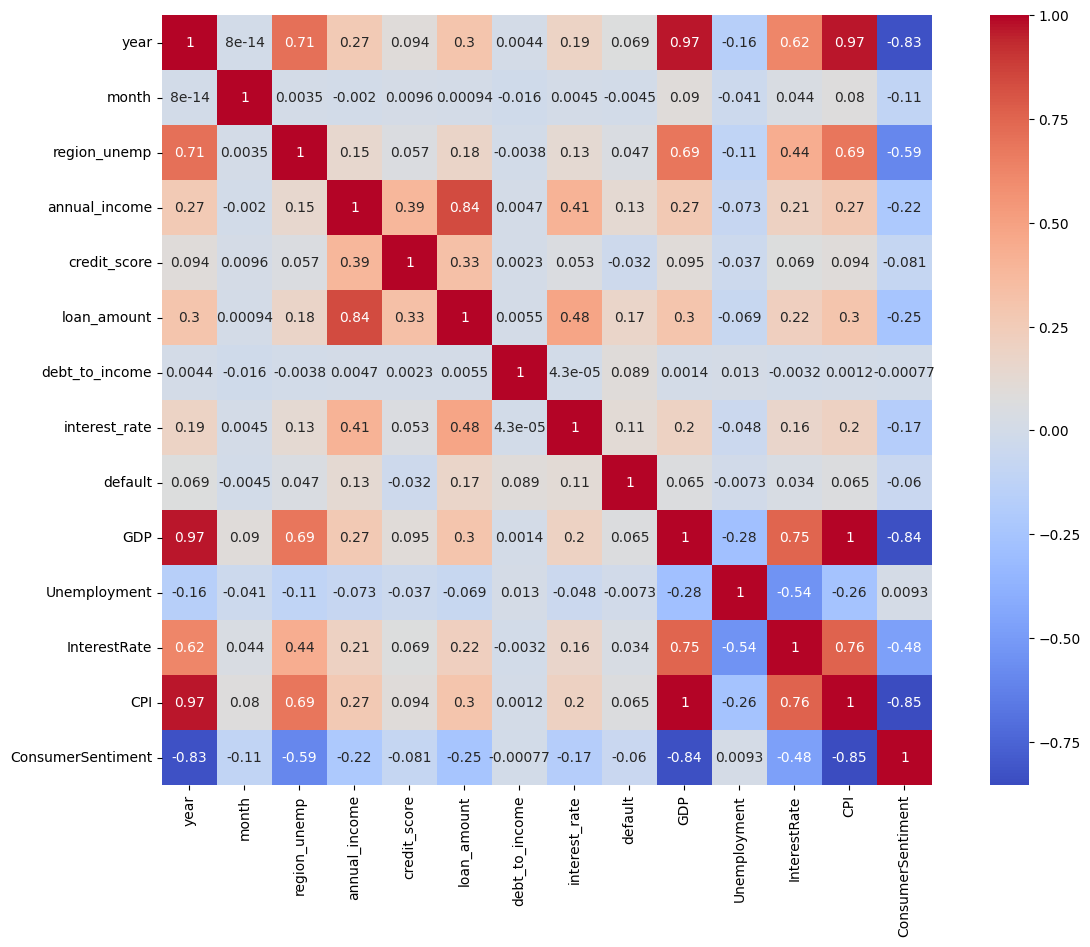

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

nums = data.select_dtypes(include = ['int','float']).columns
c = data[nums].corr()

plt.figure(figsize=(15, 10))
sns.heatmap(c, annot=True, cmap="coolwarm", square=True)
plt.show()

## Feature engineering and feature store

In [ ]:
df = pd.read_csv("data/merged_dataset_macro_adjusted.csv")

df['income_bucket'] = pd.cut(
    df['annual_income'],
    bins=[-float('inf'), 10000, 100000, float('inf')],
    labels=['low_income', 'median_income', 'high_income']
)
df['loan_to_income_ratio'] = df['loan_amount'] / df['annual_income']
df['payment_burden'] = df['interest_rate']* df['loan_amount']/ df['annual_income']
df['risk_score'] = df['credit_score'] * df['debt_to_income']
df['dti_bucket'] = pd.cut(df['debt_to_income'], bins = 3, labels=['low', 'medium', 'high'])

**Write data to Snowflake Warehouse**

In [ ]:
import snowflake.connector
from snowflake.connector.pandas_tools import write_pandas
from dotenv import load_dotenv
import os

load_dotenv()

conn = snowflake.connector.connect(
    user=os.getenv("SNOWFLAKE_USER"),
    password=os.getenv("SNOWFLAKE_PASSWORD"),
    account=os.getenv("SNOWFLAKE_ACCOUNT"),
    warehouse="SNOWFLAKE_LEARNING_WH",      
    database="CREDIT_MODELING_DATA",         
    schema="PUBLIC"                          
)

# Write DataFrame to Snowflake
success, nchunks, nrows, _ = write_pandas(
    conn=conn,
    df=df,
    table_name="LENDING_DATA",       # must already exist in Snowflake
    auto_create_table=True          # creates table if it doesn't exist
)

print(f"Success: {success} | Chunks: {nchunks} | Rows loaded: {nrows}")

**Fetch data from Snowflake**


In [ ]:
cursor = conn.cursor()
cursor.execute("SELECT * FROM LENDING_DATA LIMIT 10")
cursor.fetchall()
cursor.close()

df = pd.read_sql("SELECT * FROM LENDING_DATA", conn)
print(df.head())
conn.close()

# convert all column names to lower case
data.columns = data.columns.str.lower()
print(df.columns)

# create a copy in local storage
df.to_csv("./data/preprocessed/engineered_data.csv")

### **Offline Feature Store**

In [35]:
data_loaded = pd.read_csv("./data/preprocessed/engineered_data.csv")

# Sort for time-aware operations
data_loaded = data_loaded.sort_values(['applicant_id', 'issue_date']).reset_index(drop=True)

# Rename for cosistency
data_loaded.rename(columns = {'issue_date':'event_timestamp'}, inplace = True)
data_loaded

,event_timestamp,applicant_id,year,month,region,region_unemp,gender,race,age_group,education,...,GDP,Unemployment,InterestRate,CPI,ConsumerSentiment,income_bucket,loan_to_income_ratio,payment_burden,risk_score,dti_bucket
0,2015-01-14,201501_0,2015,1,MW,1.0,female,white,18-29,master,...,18063.529,5.7,1.88,234.747,98.1,median_income,0.333356,0.003334,162.024,medium
1,2015-01-04,201501_1,2015,1,W,1.0,female,asian,45-59,other,...,18063.529,5.7,1.88,234.747,98.1,low_income,0.333355,0.003334,165.856,medium
2,2015-01-19,201501_10,2015,1,NE,1.0,female,white,18-29,other,...,18063.529,5.7,1.88,234.747,98.1,median_income,0.333356,0.003334,167.528,medium
3,2015-01-13,201501_11,2015,1,W,1.0,female,white,60+,bachelor,...,18063.529,5.7,1.88,234.747,98.1,median_income,0.333356,0.003334,242.298,high
4,2015-01-11,201501_12,2015,1,W,1.0,female,white,30-44,highschool,...,18063.529,5.7,1.88,234.747,98.1,median_income,0.333356,0.003334,150.096,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13195,2025-12-25,202512_95,2025,12,NE,1.0,female,black,30-44,bachelor,...,31098.027,4.4,4.14,326.030,52.9,median_income,0.084014,0.000840,245.434,medium
13196,2025-12-09,202512_96,2025,12,NE,1.0,female,black,45-59,other,...,31098.027,4.4,4.14,326.030,52.9,median_income,0.084014,0.000840,198.114,medium
13197,2025-12-21,202512_97,2025,12,NE,1.0,female,white,30-44,master,...,31098.027,4.4,4.14,326.030,52.9,median_income,0.084014,0.003159,234.956,medium
13198,2025-12-04,202512_98,2025,12,MW,1.0,male,white,18-29,bachelor,...,31098.027,4.4,4.14,326.030,52.9,median_income,0.084014,0.004419,210.504,medium


In [36]:
import os
from datetime import datetime
import json

DATA_PATH = "./data/preprocessed/engineered_data.csv"
FEATURE_STORE_PATH = "./features/offline"
VERSION = "1.0"

feature_columns = [
    # keys
    'applicant_id',
    'event_timestamp',

    # raw core features
    'gender', 'race', 'age_group', 'education',
    'employment_status', 'annual_income',
    'loan_amount', 'credit_score',
    'debt_to_income', 'interest_rate',
    'region','region_unemp',

    # macro
    'GDP', 'Unemployment', 'InterestRate',
    'CPI', 'ConsumerSentiment',

    # engineered
    'income_bucket',
    'loan_to_income_ratio',
    'payment_burden',
    'risk_score',
    'dti_bucket'
]

target_cols = [
    'applicant_id',
    'event_timestamp',
    'default'
]

offline_features= data_loaded[feature_columns].copy()
offline_target= data_loaded[target_cols].copy()

version_path = os.path.join(FEATURE_STORE_PATH, VERSION)
os.makedirs(version_path, exist_ok=True)

offline_features.to_parquet(
    os.path.join(version_path, "applicant_features.parquet"),
    index=False
)

offline_target.to_parquet(
    os.path.join(version_path, "target.parquet"),
    index=False
)

# feature metadata registry
feature_metadata = []
for col in feature_columns:
    if col in ['applicant_id','event_timestamp']:
        continue

    feature_metadata.append({
        "feature_name": col,
        "dtype": str(offline_features[col].dtype),
        "created_in_version": VERSION,
        "entity": "applicant",
        "description": f"{col} feature used in credit risk modeling"
    })

metadata =  {
    "version": VERSION,
    "created_at": datetime.now().isoformat(),
    "num_rows": len(offline_features),
    "features": feature_metadata
}

with open(os.path.join(version_path, "metadata.json"), "w") as f:
    json.dump(metadata, f, indent=4)

print(f"Offline feature store v{VERSION} successfully built.")

Offline feature store v1.0 successfully built.


### **Online Feature Store**

- We use Redis for the online feature store, designed in parallel with the offline feature store (used for training) to prevent training-serving skew.

**Simulate user-level data + Real macroeconomic data for new users**

In [37]:
import pandas as pd
import random
from datetime import datetime
from fredapi import Fred

# Define possible values
genders = ["male", "female"]
races = ["white", "black", "asian", "hispanic", "other"]
age_groups = ['18-29','30-44','45-59','60+']
educations = ['highschool','bachelor','master','phd','other']
employment_statuses = ['employed', 'unemployed', 'self-employed']
regions = ['NE', 'MW', 'S', 'W']

# FRED API
fred = Fred(api_key='2ed97a4f4b2b2477270454e71cf06a64')
start = '2026-01-01'
end = '2026-01-31'


# Use last available data instead of future dates
gdp_q = fred.get_series('GDP')   # get all data
gdp_q.index = pd.to_datetime(gdp_q.index)
gdp = gdp_q.resample('M').ffill()

unemp = fred.get_series('UNRATE')
unemp.index = pd.to_datetime(unemp.index)

interest = fred.get_series('GS10')
interest.index = pd.to_datetime(interest.index)

cpi = fred.get_series('CPIAUCSL')
cpi.index = pd.to_datetime(cpi.index)

cons_sent = fred.get_series('UMCSENT')
cons_sent.index = pd.to_datetime(cons_sent.index)

# Pick the **latest values** from the Series
macro_snapshot = {
    "GDP": float(gdp.iloc[-1]),
    "Unemployment": float(unemp.iloc[-1]),
    "InterestRate": float(interest.iloc[-1]),
    "CPI": float(cpi.iloc[-1]),
    "ConsumerSentiment": float(cons_sent.iloc[-1])
}


# Number of new simulated applicants
N = 5
today = datetime.today()
simulated_data = []

def generate_income_bucket(income):
    if income < 20000:
        return "Low"
    elif income < 50000:
        return "Medium"
    else:
        return "High"

for i in range(N):
    applicant_id = f"new_{today.strftime('%Y%m%d')}_{i}"

    features = {
        "applicant_id": applicant_id,
        "gender": random.choice(genders),
        "race": random.choice(races),
        "age_group": random.choice(age_groups),
        "education": random.choice(educations),
        "employment_status": random.choice(employment_statuses),
        "annual_income": round(random.uniform(10000, 100000), 2),
        "loan_amount": round(random.uniform(1000, 50000), 2),
        "credit_score": random.randint(300, 850),
        "debt_to_income": round(random.uniform(0.1, 0.6), 2),
        "interest_rate": round(random.uniform(2.5, 15.0), 2),
        "region": random.choice(regions),
        "region_unemp": round(random.uniform(2.0, 15.0), 2),
    }

    features["income_buckets"] = generate_income_bucket(features["annual_income"])
    features.update(macro_snapshot)

    simulated_data.append(features)

df_simulated = pd.DataFrame(simulated_data)
df_simulated


C:\Users\adm\AppData\Local\Temp\ipykernel_15848\390576599.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  gdp = gdp_q.resample('M').ffill()


,applicant_id,gender,race,age_group,education,employment_status,annual_income,loan_amount,credit_score,debt_to_income,interest_rate,region,region_unemp,income_buckets,GDP,Unemployment,InterestRate,CPI,ConsumerSentiment
0,new_20260221_0,male,black,60+,highschool,unemployed,98852.46,20741.89,492,0.34,11.83,W,5.88,High,31490.07,4.3,4.21,326.588,56.4
1,new_20260221_1,male,hispanic,60+,highschool,employed,31913.54,32711.39,768,0.36,12.58,S,14.72,Medium,31490.07,4.3,4.21,326.588,56.4
2,new_20260221_2,female,black,18-29,master,self-employed,91264.65,11203.97,468,0.55,6.05,NE,9.76,High,31490.07,4.3,4.21,326.588,56.4
3,new_20260221_3,male,white,45-59,master,self-employed,74515.54,43560.39,633,0.51,10.36,S,9.28,High,31490.07,4.3,4.21,326.588,56.4
4,new_20260221_4,male,asian,30-44,other,employed,14887.75,7655.88,426,0.25,8.63,NE,6.47,Low,31490.07,4.3,4.21,326.588,56.4


In [38]:
print(df_simulated)

     applicant_id  gender      race age_group   education employment_status  \
0  new_20260221_0    male     black       60+  highschool        unemployed   
1  new_20260221_1    male  hispanic       60+  highschool          employed   
2  new_20260221_2  female     black     18-29      master     self-employed   
3  new_20260221_3    male     white     45-59      master     self-employed   
4  new_20260221_4    male     asian     30-44       other          employed   

   annual_income  loan_amount  credit_score  debt_to_income  interest_rate  \
0       98852.46     20741.89           492            0.34          11.83   
1       31913.54     32711.39           768            0.36          12.58   
2       91264.65     11203.97           468            0.55           6.05   
3       74515.54     43560.39           633            0.51          10.36   
4       14887.75      7655.88           426            0.25           8.63   

  region  region_unemp income_buckets       GDP  Unemplo

**Shared Feature logic---> For both offline and online feature store**

In [39]:
def compute_engineered_features(df):
    df = df.copy()
    df['income_bucket'] = pd.cut( df['annual_income'],bins=[-float('inf'), 10000, 100000, float('inf')], labels=['low_income', 'median_income', 'high_income'])
    df['loan_to_income_ratio'] = df['loan_amount'] / df['annual_income']
    df['payment_burden'] = df['interest_rate']* df['loan_amount']/ df['annual_income']
    df['risk_score'] = df['credit_score'] * df['debt_to_income']
    df['dti_bucket'] = pd.cut(df['debt_to_income'], bins = 3, labels=['low', 'medium', 'high'])
    return df

**1. Local Redis**

*Existing snapshot for latest users*

In [40]:
import pandas as pd
import redis
import json

FEATURE_VERSION  = "v1.0"

# connect to redis
r = redis.Redis(host = "localhost", port = 6379, decode_responses = True)

# Load Offline feature files
df_offline = pd.read_parquet("./features/offline/1.0/applicant_features.parquet")
df_offline = compute_engineered_features(df_offline)

# ensure timestamp column is datetime 
df_offline['event_timestamp'] = pd.to_datetime(df_offline['event_timestamp'])

# Keep latest per applicant
df_latest = df_offline.sort_values("event_timestamp").groupby("applicant_id").tail(1)

# Push to Redis (no deletes, versioned keys)
for _, row in df_latest.iterrows():
    key = f"feature:{FEATURE_VERSION}:applicant:{row['applicant_id']}"
    cols_to_drop = [c for c in ["applicant_id", "default"] if c in row.index]
    feature_dict = row.drop(cols_to_drop).to_dict()

    # Convert all values to str, int, or float
    for k, v in feature_dict.items():
        if pd.isna(v):
            feature_dict[k] = ""
        elif isinstance(v, (pd.Timestamp, datetime)):
            feature_dict[k] = v.strftime("%Y-%m-%d %H:%M:%S")
        elif isinstance(v, (pd.Categorical,)):
            feature_dict[k] = str(v)
        elif isinstance(v, (int, float, str)):
            continue  # OK
        else:
            feature_dict[k] = str(v)

    feature_dict["feature_timestamp"] = row["event_timestamp"].strftime("%Y-%m-%d %H:%M:%S")
    r.hset(key, mapping=feature_dict)


*Add new Users*

In [41]:
df_new = pd.DataFrame(simulated_data)
df_new = compute_engineered_features(df_new)

# Push to Redis
for _, row in df_new.iterrows():
    key = f"feature:{FEATURE_VERSION}:applicant:{row['applicant_id']}"
    feature_dict = row.drop("applicant_id").to_dict()
    feature_dict["feature_timestamp"] = today.strftime("%Y-%m-%d %H:%M:%S")
    r.hset(key, mapping=feature_dict)

In [42]:
creditscore = r.hget("feature:v1.0:applicant:new_20260216_0", "credit_score")
print(creditscore)
all_info = r.hgetall("feature:v1.0:applicant:new_20260216_0")
print(all_info)

348
{'year': '2026', 'month': '2', 'gender': 'female', 'race': 'white', 'age_group': '60+', 'education': 'master', 'employment_status': 'employed', 'annual_income': '38583.75', 'loan_amount': '14185.41', 'credit_score': '348', 'debt_to_income': '0.44', 'interest_rate': '6.49', 'region': 'MW', 'region_unemp': '5.38', 'income_buckets': 'Medium', 'GDP': '31098.027', 'Unemployment': '4.3', 'InterestRate': '4.21', 'CPI': '326.588', 'ConsumerSentiment': '52.9', 'income_bucket': 'median_income', 'loan_to_income_ratio': '0.3676524443580523', 'payment_burden': '2.3860643638837593', 'risk_score': '153.12', 'dti_bucket': 'high', 'feature_timestamp': '2026-02-16 17:36:26'}


In [ ]:
import json
import os

# Save snapshot
all_data = {}

for key in r.scan_iter("applicant:*"):
    all_data[key] = r.hgetall(key)
    os.makedirs("./features/Online", exist_ok=True)
with open("./features/Online/redis_snapshot_v1.json", "w") as f:
    json.dump(all_data, f, indent=4)

In [44]:
nnn

NameError: name 'nnn' is not defined

**2. Cloud Redis**

In [ ]:
from dotenv import load_dotenv
import os
import redis

load_dotenv()

r_cloud = redis.Redis(
    host= os.getenv("REDIS_HOST"),
    port= os.getenv("REDIS_PORT"),
    username= os.getenv("REDIS_USERNAME"),
    password= os.getenv("REDIS_PASSWORD"),
    decode_responses= True
)

# Push to Redis cloud(Existing users)
for _, row in df_latest.iterrows():
    key = f"feature:{FEATURE_VERSION}:applicant:{row['applicant_id']}"
    cols_to_drop = [c for c in ["applicant_id", "default"] if c in row.index]
    feature_dict = row.drop(cols_to_drop).to_dict()

    # Convert all values to str, int, or float
    for k, v in feature_dict.items():
        if pd.isna(v):
            feature_dict[k] = ""
        elif isinstance(v, (pd.Timestamp, datetime)):
            feature_dict[k] = v.strftime("%Y-%m-%d %H:%M:%S")
        elif isinstance(v, (pd.Categorical,)):
            feature_dict[k] = str(v)
        elif isinstance(v, (int, float, str))  :
            continue  # OK
        else:
            feature_dict[k] = str(v)

    feature_dict["feature_timestamp"] = row["event_timestamp"].strftime("%Y-%m-%d %H:%M:%S")
    r_cloud.hset(key, mapping=feature_dict)

# Push to Redis cloud(New users)
for _, row in df_new.iterrows():
    key = f"feature:{FEATURE_VERSION}:applicant:{row['applicant_id']}"
    feature_dict = row.drop("applicant_id").to_dict()
    feature_dict["feature_timestamp"] = today.strftime("%Y-%m-%d %H:%M:%S")
    r_cloud.hset(key, mapping=feature_dict)

creditscore = r_cloud.hget("feature:v1.0:applicant:new_20260216_0", "gender")
all_info = r_cloud.hgetall("feature:v1.0:applicant:new_20260216_0")
print(creditscore)
print(all_info)

---
---

**Note:**

`df_full.itterows()` lets us go through each row of our DataFrame one at a time, giving us both the row's index and data in that row as a Series (list-like structure where each item is a column value).

Think of it like reading a table line by line. For each row, we get:
- The row number or label(index)
- All data in that row (values from each group)

Example:

```
import pandas as pd
df = pd.DataFrame ({
    'Name': ['Alice', 'Bob', 'Charlie'],
    'Age': [25, 30, 35],
    'City': ['New York', 'London', 'Tokyo'] 
    })

# use itterows to get through each row
for index, row in df.itterows():
    print(f "Index: {index}, Name: {row['Name']}, Age: {row['Age']}, City: {row['City']}" )
```

---
---

## Temporal split

- We shall use the walk-forward validation.

In [ ]:
years = sorted(df['year'].unique())
years

[2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]

In [ ]:

cat_features = ['region','gender','race','age_group','education', 'employment_status']

for i in range(2, len(years)):
    train_years = years[:i]
    print(train_years)
    test_year = years[i]
    print(test_year)
    train_df = df[df['year'].isin(train_years)].copy()
    test_df = df[df['year']==test_year].copy()
    nums = train_df.select_dtypes(include = ['float', 'int']).columns
    xtrain = train_df[nums] + train_df[cat_features]
    ytrain = train_df['default']
    xtest = test_df[nums] + test_df[cat_features]
    ytest = test_df['default']


[2015, 2016]
2017
[2015, 2016, 2017]
2018
[2015, 2016, 2017, 2018]
2019
[2015, 2016, 2017, 2018, 2019]
2020
[2015, 2016, 2017, 2018, 2019, 2020]
2021
[2015, 2016, 2017, 2018, 2019, 2020, 2021]
2022
[2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]
2023
[2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
2024
[2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
2025


In [ ]:
xtrain.shape, xtest.shape

((12000, 23), (1200, 23))

In [ ]:
train_df

,applicant_id,year,month,region,region_unemp,gender,race,age_group,education,employment_status,...,GDP,Unemployment,InterestRate,CPI,ConsumerSentiment,income_bucket,loan_to_income_ratio,payment_burden,risk_score,dti_bucket
issue_date,,,,,,,,,,,,,,,,,,,,,
2015-01-14,201501_0,2015,1,MW,1.0,female,white,18-29,master,employed,...,18063.529,5.7,1.88,234.747,98.1,median_income,0.333356,0.003334,162.024,medium
2015-01-04,201501_1,2015,1,W,1.0,female,asian,45-59,other,unemployed,...,18063.529,5.7,1.88,234.747,98.1,low_income,0.333355,0.003334,165.856,medium
2015-01-06,201501_2,2015,1,S,1.0,female,white,30-44,other,employed,...,18063.529,5.7,1.88,234.747,98.1,median_income,0.333356,0.003334,148.554,medium
2015-01-19,201501_3,2015,1,S,1.0,female,white,18-29,bachelor,employed,...,18063.529,5.7,1.88,234.747,98.1,median_income,0.333356,0.003334,113.088,low
2015-01-06,201501_4,2015,1,NE,1.0,male,white,18-29,master,employed,...,18063.529,5.7,1.88,234.747,98.1,high_income,0.333356,0.016534,254.562,high
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-20,202412_95,2024,12,S,1.0,female,white,30-44,master,employed,...,29825.182,4.1,4.39,317.603,74.0,median_income,0.056432,0.000564,165.572,medium
2024-12-27,202412_96,2024,12,MW,1.0,female,hispanic,45-59,bachelor,employed,...,29825.182,4.1,4.39,317.603,74.0,median_income,0.056432,0.000564,115.368,low
2024-12-08,202412_97,2024,12,MW,1.0,female,asian,45-59,bachelor,employed,...,29825.182,4.1,4.39,317.603,74.0,median_income,0.056432,0.002652,240.320,medium


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12000 entries, 2015-01-14 to 2024-12-18
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   applicant_id          12000 non-null  object  
 1   year                  12000 non-null  int64   
 2   month                 12000 non-null  int64   
 3   region                12000 non-null  object  
 4   region_unemp          12000 non-null  float64 
 5   gender                12000 non-null  object  
 6   race                  12000 non-null  object  
 7   age_group             12000 non-null  object  
 8   education             12000 non-null  object  
 9   employment_status     12000 non-null  object  
 10  annual_income         12000 non-null  float64 
 11  credit_score          12000 non-null  int32   
 12  loan_amount           12000 non-null  float64 
 13  debt_to_income        12000 non-null  float64 
 14  interest_rate         12000 non-null 